In [123]:
from io import StringIO
import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
pd.set_option('display.max_columns', 50)

In [124]:
aws_access_key_id = os.getenv('AWS_ACCESS_KEY')
aws_secret_key = os.getenv('AWS_SECRET_KEY')

In [125]:
def read_csv_from_s3(bucket: str, path: str, filename: str) -> pd.DataFrame:
    
    """ Downloads a csv file from an S3 bucket.
    
    Parameters
    -----------
    bucket: str
        The bucket where the files at.
        
    path: str
        The folders to the file.
        
    filename: str
        Name of the file.
        
    Returns
    --------
    pd.DataFrame
        A DataFrame of the downloaded file.
    
    """
    
    s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_key)
    
    full_path = f'{path}{filename}'
    
    object = s3.get_object(Bucket=bucket, Key=full_path)
    object = object['Body'].read().decode('utf-8')
    output_df = pd.read_csv(StringIO(object))
    
    return output_df

In [126]:
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_key)
bucket = 'cubix-chicago-taxi-ms'

community_areas_path = 'transformed_data/community_areas/'
company_path = 'transformed_data/company/'
date_path = 'transformed_data/date/'
payment_type_path = 'transformed_data/payment_type/'
taxi_trips_path = 'transformed_data/taxi_trips/'
weather_path = 'transformed_data/weather/'

In [127]:
community_areas = read_csv_from_s3(bucket=bucket, path=community_areas_path, filename='community_areas_master.csv')
company = read_csv_from_s3(bucket=bucket, path=company_path, filename='company_master.csv')
date = read_csv_from_s3(bucket=bucket, path=date_path, filename='date_dimension.csv')
payment_type = read_csv_from_s3(bucket=bucket, path=payment_type_path, filename='payment_type_master.csv')

In [128]:
trips_list = []
weather_list = []

In [129]:
for file in s3.list_objects(Bucket=bucket, Prefix=taxi_trips_path)['Contents']:
    taxi_trip_key = file['Key']
    
    if taxi_trip_key.split('/')[-1].strip() != '':
        if taxi_trip_key.split('.')[1] == 'csv':
            
            filename = taxi_trip_key.split('/')[-1]
            trip = read_csv_from_s3(bucket=bucket, path=taxi_trips_path, filename=filename)

            trips_list.append(trip)
            print(f'{filename} has been added.')

taxi_2023-12-08.csv has been added.
taxi_2023-12-09.csv has been added.
taxi_2023-12-10.csv has been added.
taxi_2023-12-11.csv has been added.
taxi_2023-12-12.csv has been added.
taxi_2023-12-13.csv has been added.
taxi_2023-12-14.csv has been added.
taxi_2023-12-15.csv has been added.
taxi_2023-12-16.csv has been added.
taxi_2023-12-17.csv has been added.
taxi_2023-12-18.csv has been added.
taxi_2023-12-19.csv has been added.
taxi_2023-12-20.csv has been added.
taxi_2023-12-21.csv has been added.
taxi_2023-12-22.csv has been added.
taxi_2023-12-23.csv has been added.
taxi_2023-12-24.csv has been added.
taxi_2023-12-25.csv has been added.
taxi_2023-12-26.csv has been added.
taxi_2023-12-27.csv has been added.


In [130]:
trips = pd.concat(trips_list, ignore_index=True)

In [131]:
trips.shape

(271053, 20)

In [132]:
for file in s3.list_objects(Bucket=bucket, Prefix=weather_path)['Contents']:
    weather_key = file['Key']
    
    if weather_key.split('/')[-1].strip() != '':
        if weather_key.split('.')[1] == 'csv':
            
            filename = weather_key.split('/')[-1]
            weather_daily = read_csv_from_s3(bucket=bucket, path=weather_path, filename=filename)

            weather_list.append(weather_daily)
            print(f'{filename} has been added.')

weather_2023-12-08.csv has been added.
weather_2023-12-09.csv has been added.
weather_2023-12-10.csv has been added.
weather_2023-12-11.csv has been added.
weather_2023-12-12.csv has been added.
weather_2023-12-13.csv has been added.
weather_2023-12-14.csv has been added.
weather_2023-12-15.csv has been added.
weather_2023-12-16.csv has been added.
weather_2023-12-17.csv has been added.
weather_2023-12-18.csv has been added.
weather_2023-12-19.csv has been added.
weather_2023-12-20.csv has been added.
weather_2023-12-21.csv has been added.
weather_2023-12-22.csv has been added.
weather_2023-12-23.csv has been added.
weather_2023-12-24.csv has been added.
weather_2023-12-25.csv has been added.
weather_2023-12-26.csv has been added.
weather_2023-12-27.csv has been added.


In [133]:
weather = pd.concat(weather_list, ignore_index=True)

In [134]:
weather.shape

(480, 5)

### Join them together

In [135]:
trips_full = pd.merge(trips, weather, left_on='datetime_for_weather', right_on='datetime', how='inner')
trips_full = trips_full.drop(columns=['datetime'])

In [136]:
trips_full = pd.merge(trips_full, company, left_on='company_id', right_on='company_id', how='inner')
trips_full = trips_full.drop(columns=['company_id'])

In [137]:
trips_full = pd.merge(trips_full, payment_type, left_on='payment_type_id', right_on='payment_type_id', how='inner')
trips_full = trips_full.drop(columns=['payment_type_id'])

In [138]:
trips_full = pd.merge(trips_full, community_areas, left_on='pickup_community_area_id', right_on='area_code', how='inner')
trips_full = trips_full.drop(columns=['pickup_community_area_id', 'area_code'])
trips_full.rename(columns={'community_name': 'pickup_community_area_name'}, inplace=True)

In [139]:
trips_full = pd.merge(trips_full, community_areas, left_on='dropoff_community_area_id', right_on='area_code', how='inner')
trips_full = trips_full.drop(columns=['dropoff_community_area_id', 'area_code'])
trips_full.rename(columns={'community_name': 'dropoff_community_area_name'}, inplace=True)

In [140]:
date['date'] = pd.to_datetime(date['date'])
trips_full['trip_start_timestamp'] = pd.to_datetime(trips_full['trip_start_timestamp'])
trips_full['trip_end_timestamp'] = pd.to_datetime(trips_full['trip_end_timestamp'])

trips_full['trip_start_date'] = trips_full['trip_start_timestamp'].dt.date
trips_full['trip_start_date'] = pd.to_datetime(trips_full['trip_start_date'])

trips_full['trip_end_date'] = trips_full['trip_end_timestamp'].dt.date
trips_full['trip_end_date'] = pd.to_datetime(trips_full['trip_end_date'])

In [141]:
trips_full = pd.merge(trips_full, date, left_on='trip_start_date', right_on='date', how='inner')
trips_full = trips_full.drop(columns=['date'])

In [142]:
trips_full.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,temperature,wind_speed,rain,precipitation,company,payment_type,pickup_community_area_name,dropoff_community_area_name,trip_start_date,trip_end_date,year,month,day,day_of_week,is_weekend
0,fef2e2bba8db20702cfac5c6ef67c6c56d078741,a9263292f54a406cd0fb2bac808b9aaca91f770ad5e0fd...,2023-12-08 23:45:00,2023-12-09 00:00:00,780,3.50,12.25,0.0,0.0,1.0,13.25,41.878866,-87.625192,41.901207,-87.676356,2023-12-08 23:00:00,10.7,19.6,0.0,0.0,Taxi Affiliation Services,Cash,Loop,West Town,2023-12-08,2023-12-09,2023,12,8,5,False
1,7e6476d1e0777fe7730b0691b4968dd0aebbc2fa,25f401ef5193d27d5a1baced30b0597335466ae6f000b1...,2023-12-08 23:45:00,2023-12-08 23:45:00,371,1.08,6.50,6.0,0.0,0.0,13.00,41.899602,-87.633308,41.874005,-87.663518,2023-12-08 23:00:00,10.7,19.6,0.0,0.0,Chicago Independents,Credit Card,Near North Side,Near West Side,2023-12-08,2023-12-08,2023,12,8,5,False
2,7e3f52efcb39f299dec2b189683991079555035d,f705c825446b6687d3b45d5bb04a7a29720306923943f3...,2023-12-08 23:45:00,2023-12-09 00:00:00,360,0.00,6.75,0.0,0.0,0.0,6.75,41.899602,-87.633308,41.922686,-87.649489,2023-12-08 23:00:00,10.7,19.6,0.0,0.0,Taxi Affiliation Services,Cash,Near North Side,Lincoln Park,2023-12-08,2023-12-09,2023,12,8,5,False
3,836e0d23509b4683c8b22437151d8495b41847e2,f32c0c8e63d4e5d4bfc7e9d57e5d0f6dcf28450850245d...,2023-12-08 23:45:00,2023-12-08 23:45:00,360,0.00,6.50,0.0,0.0,1.0,7.50,41.885300,-87.642808,41.884987,-87.620993,2023-12-08 23:00:00,10.7,19.6,0.0,0.0,Taxi Affiliation Services,Cash,Near West Side,Loop,2023-12-08,2023-12-08,2023,12,8,5,False
4,819ddf1ae755696db2e57850f6ef68615e21c39d,687e4d96be3cc961be4ce4608d2ad3bfadf54e3bbe80d7...,2023-12-08 23:45:00,2023-12-09 00:00:00,821,8.41,22.50,4.0,0.0,5.5,32.50,41.979071,-87.903040,41.979071,-87.903040,2023-12-08 23:00:00,10.7,19.6,0.0,0.0,City Service,Credit Card,O'Hare,O'Hare,2023-12-08,2023-12-09,2023,12,8,5,False


### Top 10 companies by total fare

In [143]:
companies_by_total_fare = pd.pivot_table(
    trips_full, 
    values=['fare'], 
    index=['company'], 
    aggfunc='sum', 
    fill_value=0
)

In [144]:
top10_companies_by_total_fare = companies_by_total_fare.sort_values('fare', ascending=False).head(10)

In [145]:
x = top10_companies_by_total_fare.index
y = top10_companies_by_total_fare['fare']

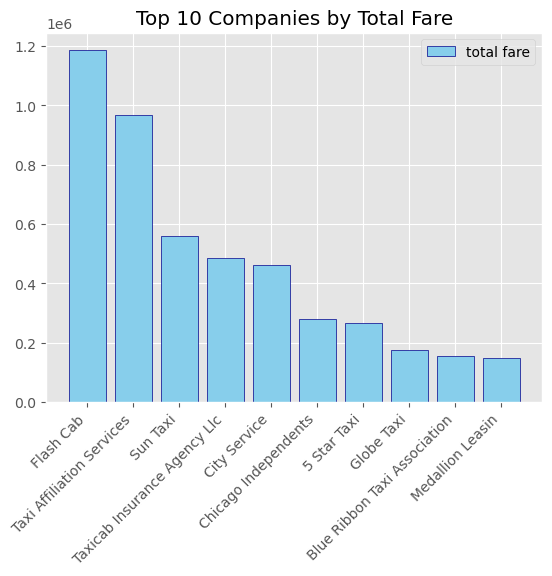

In [146]:
plt.figure()
plt.bar(x, y, color='skyblue', edgecolor='darkblue')
plt.title('Top 10 Companies by Total Fare')
plt.xticks(rotation=45, ha='right')
plt.legend(['total fare'], loc='upper right')
plt.savefig('top10_companies_by_total_fare.png', dpi=300, bbox_inches='tight')
plt.show()

### Top 10 pickup community areas by rides count

In [147]:
pickup_community_areas_by_rides_count = pd.pivot_table(
    trips_full, 
    values=['trip_id'], 
    index=['pickup_community_area_name'], 
    aggfunc='count', 
    fill_value=0
)

In [148]:
top10_pickup_community_areas_by_rides_count = pickup_community_areas_by_rides_count.sort_values('trip_id', ascending=False).head(10)

In [149]:
x = top10_pickup_community_areas_by_rides_count.index
y = top10_pickup_community_areas_by_rides_count['trip_id']

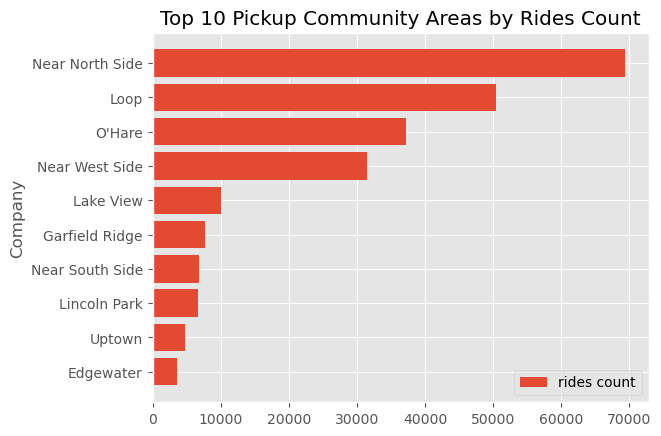

In [150]:
plt.figure()
plt.barh(x, y)
plt.title('Top 10 Pickup Community Areas by Rides Count')
plt.gca().invert_yaxis()
plt.ylabel('Company')
plt.legend(['rides count'], loc='lower right')
plt.savefig('top10_pickup_community_areas_by_rides_count.png', dpi=300, bbox_inches='tight')
plt.show()

### Weekday comparison by trip total

In [151]:
weekday_comparison_by_trip_total = pd.pivot_table(
    trips_full, 
    values=['trip_total'], 
    index=['day_of_week'], 
    aggfunc='sum', 
    fill_value=0
)

In [152]:
weekday_comparison_by_trip_total = weekday_comparison_by_trip_total.rename(
    {1: 'Monday', 
     2: 'Tuesday',
     3: 'Wednesday',
     4: 'Thursday',
     5: 'Friday',
     6: 'Saturday',
     7: 'Sunday'
    }
)

In [153]:
x = weekday_comparison_by_trip_total.index
y = weekday_comparison_by_trip_total['trip_total']

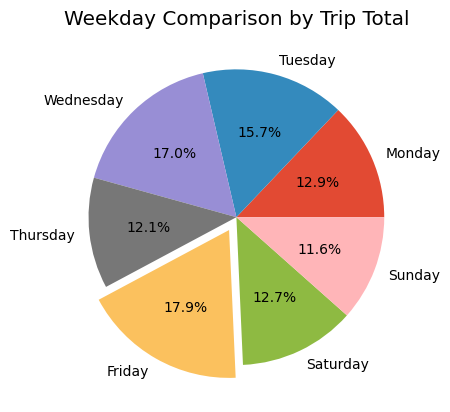

In [154]:
explode_slices = (0, 0, 0, 0, 0.1, 0, 0)

plt.figure()
plt.pie(y, labels=x, explode=explode_slices, autopct='%.1f%%')
plt.title('Weekday Comparison by Trip Total')
plt.savefig('weekday_comparison_by_trip_total.png', dpi=300, bbox_inches='tight')
plt.show()

### Total trip miles by date

In [155]:
total_trip_miles_by_date = pd.pivot_table(
    trips_full, 
    values=['trip_miles'], 
    index=['trip_start_date'], 
    aggfunc='sum', 
    fill_value=0
)

In [156]:
x = total_trip_miles_by_date.index
y = total_trip_miles_by_date['trip_miles']

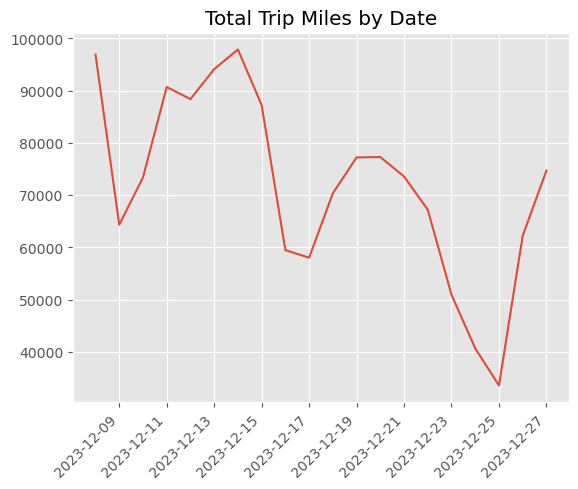

In [157]:
plt.figure()
plt.plot(x, y)
plt.title('Total Trip Miles by Date')
plt.xticks(rotation=45, ha='right')
plt.savefig('total_trip_miles_by_date.png', dpi=300, bbox_inches='tight')
plt.show()

### Payment options by trip total

In [158]:
trip_total_by_payment_type = pd.pivot_table(
    trips_full, 
    values=['trip_total'], 
    index=['payment_type'], 
    aggfunc='sum', 
    fill_value=0
)

In [159]:
x = trip_total_by_payment_type.index
y = trip_total_by_payment_type['trip_total']

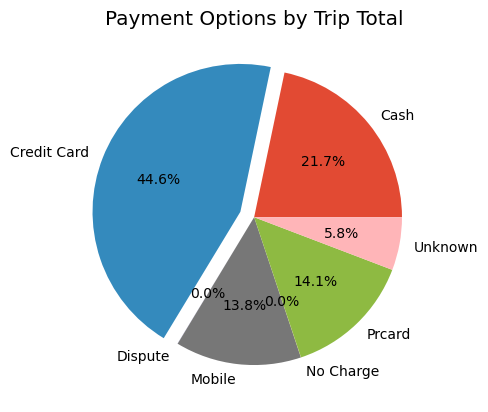

In [160]:
explode_slices = (0, 0.1, 0, 0, 0, 0, 0)

plt.figure()
plt.pie(y, labels=x, explode=explode_slices, autopct='%.1f%%')
plt.title('Payment Options by Trip Total')
plt.savefig('trip_total_by_payment_type.png', dpi=300, bbox_inches='tight')
plt.show()